In [1]:
  "FCN ATROUS TESTING"

'FCN ATROUS TESTING'

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 07 11:04:06 2018

@author: Nicholus
"""

# key issues to note include the loss function, the softmax
from numpy.random import seed,randint
import time
import keras
import numpy as np
import h5py
from keras.models import Sequential, Model
from keras.layers import Input, Lambda,LeakyReLU
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Add
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,Concatenate
#from keras.preprocessing import image, datagen
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import theano.tensor as T
from keras import backend as K
from osgeo import gdal
from theano import ifelse
import matplotlib.pyplot as plt
from PIL import Image
seed(352)
K.set_image_dim_ordering("th")
t0 = time.time()

nb_epoch = 200
batch_size = 32
nc = 5

_epsilon = 1e-6

Using Theano backend.
Using cuDNN version 7005 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:05:00.0)


In [3]:
#customize the softmax activation function
def softmax_4d(softmax_input):
    """Elementwise softmax for 4d tensors."""
    si = softmax_input.reshape((softmax_input.shape[0],
                                softmax_input.shape[1], -1))
    shp = (si.shape[0], 1, si.shape[2])
    exp = K.exp(si - si.max(axis=1).reshape(shp))
    out = (exp / exp.sum(axis=1).reshape(shp)).reshape(softmax_input.shape)
    return out

#customize the loss function

def categorical_CE2D(y_true, y_pred):
    y_pred = K.clip(y_pred, _epsilon, 1.0 - _epsilon)
    cce = K.mean(-K.sum(y_true*K.log(y_pred), axis=[1]))
    return cce

def categorical_accuracy2D(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=1),
                  K.argmax(y_pred, axis=1)))
				  
def to_categorical_4d(y, nc):
    """Convert a reclassed ground truth array to one-hot encoding
    
    Keyword arguments:
    y -- ground truth image
    nc -- number of classes
    """
    Y = np.zeros((y.shape[0],
                  nc,
                  y.shape[2],
                  y.shape[3]),
                  dtype=np.int32)
    
    for h in range(y.shape[0]):
        for i in range(y.shape[2]):
            for j in range(y.shape[3]):
                if y[h, 0, i, j] != 0:
                    Y[h, y[h, 0, i, j]-1, i, j] = 1
                else:
                    continue
    
    return Y
"""
def add_common_layers(y):
    y = BatchNormalization(axis=1)(y) #should i define the axis for BN? what is the effect of not specifying the BN
    y = Activation ('relu')(y)
    
    return y
"""

def add_common_layers(y):
    y = Activation ('relu')(y)
    #y=LeakyReLU(alpha=0.1)(y)
    y = BatchNormalization(axis=1)(y) #should i define the axis for BN? what is the effect of not specifying the BN
    #y = Activation ('relu')(y)
    #y=Dropout(0.2)(y)
    return y

def block_1(inpt):
	x = inpt
	x_0 = ZeroPadding2D((4, 4))(x)
	x_0 = Conv2D(64, (5, 5), padding = 'valid', dilation_rate = (2,2))(x_0)
	x_0 = add_common_layers(x_0)
	x_0 = ZeroPadding2D((1, 1))(x_0)
	x_0 = MaxPooling2D(pool_size=(3, 3),strides=1)(x_0)
	return x_0
	
def block_2(inp):
	x_1 = inp
	x_2 = ZeroPadding2D((2, 2))(x_1)
	x_2 = Conv2D(64, (3, 3), padding = 'valid', dilation_rate = (2,2))(x_2)
	x_2 = add_common_layers(x_2)
	x_2 = ZeroPadding2D((1, 1))(x_2)
	x_2 = MaxPooling2D(pool_size=(3, 3),strides=1)(x_2)
	return x_2
""" 
def block_1(inpt):
	x = inpt
	x_0 = ZeroPadding2D((2, 2))(x)
	x_0 = Conv2D(64, (5, 5), padding = 'valid')(x_0)
	x_0 = add_common_layers(x_0)
	x_0 = ZeroPadding2D((1, 1))(x_0)
	x_0 = MaxPooling2D(pool_size=(3, 3),strides=1)(x_0)
	return x_0
	
def block_2(inp):
	x_1 = inp
	x_2 = ZeroPadding2D((1, 1))(x_1)
	x_2 = Conv2D(64, (3, 3), padding = 'valid')(x_2)
	x_2 = add_common_layers(x_2)
	x_2 = ZeroPadding2D((1, 1))(x_2)
	x_2 = MaxPooling2D(pool_size=(3, 3),strides=1)(x_2)
	return x_2
"""

" \ndef block_1(inpt):\n\tx = inpt\n\tx_0 = ZeroPadding2D((2, 2))(x)\n\tx_0 = Conv2D(64, (5, 5), padding = 'valid')(x_0)\n\tx_0 = add_common_layers(x_0)\n\tx_0 = ZeroPadding2D((1, 1))(x_0)\n\tx_0 = MaxPooling2D(pool_size=(3, 3),strides=1)(x_0)\n\treturn x_0\n\t\ndef block_2(inp):\n\tx_1 = inp\n\tx_2 = ZeroPadding2D((1, 1))(x_1)\n\tx_2 = Conv2D(64, (3, 3), padding = 'valid')(x_2)\n\tx_2 = add_common_layers(x_2)\n\tx_2 = ZeroPadding2D((1, 1))(x_2)\n\tx_2 = MaxPooling2D(pool_size=(3, 3),strides=1)(x_2)\n\treturn x_2\n"

In [25]:
_datadir = "H:/BUKAVU-2018/PRELIM_CNN/"
tutorialdir = "H:/tutorial_fcn/"
#w8fname = _datadir+\
#      "weights/fcn_gray_v3.hdf5"
w8fname = tutorialdir+\
      "weights/fcn_weakly_geobia3.hdf5"



In [5]:
#the number of input channels
nb = 3

In [6]:
def nulltozero(arr):
    arrcopy = np.copy(arr)
    low_values_flags = arrcopy < 0 #0.7,0  
    arrcopy[low_values_flags]=0
    return arrcopy

In [7]:
#functions for loading the images and converting them to arrays

def img_to_array(*images):
    """Convert an image or list of images to numpy arrays.

    Keyword arguments:
    *images -- list containing the images to be converted
    """
    imgarrays = []
    i = 0
    for img in images:
        arr = gtiff_to_array(img)
        imgarrays.append(arr)
    return imgarrays


def gtiff_to_array(imgfname):                                      
    """Transform a geotiff to numpy array.

    Keyword arguments:
    imgfnames -- filename of image to convert
    """
    ds = gdal.Open(imgfname)
    for band in range(ds.RasterCount):
        band += 1
        if band == 1:
            arr = np.array(ds.GetRasterBand(band).ReadAsArray())
            arr = np.expand_dims(arr, axis=2)
        else:
            concat = np.array(ds.GetRasterBand(band).ReadAsArray())
            concat = np.expand_dims(concat, axis=2)
            arr = np.concatenate((arr,
                                  concat),
                                 axis=2)
    return arr

def reclassgts2(gtsarray):
    """Reclassify ground truth dataset array to single class numbers.

    Keyword arguments:
    gtsarray -- the ground truth dataset array
    """
    reclassarray = np.zeros(shape=(gtsarray.shape[0], gtsarray.shape[1]),
                            dtype=np.uint8)
    cnum = 1
    mask = np.logical_or(np.logical_or(gtsarray[:,:,0]==1,gtsarray[:,:,0]==3),gtsarray[:,:,0]==4)
    reclassarray[mask]=cnum
	
    cnum2 = 2
    mask = np.logical_or(gtsarray[:,:,0]==2,gtsarray[:,:,0]==2)
    reclassarray[mask] = cnum2
    return reclassarray

In [8]:
def build_model(psize1_row,psize1_col,nb,w8fname):
    inp = Input(shape=(3, psize1_row, psize1_col))
    x0=block_1(inp)
    x1=block_1(x0)
    x2=block_2(x1)
    x3=block_2(x2)
    x4=block_2(x3)
    x5=block_2(x4)
    x6=block_2(x5)
    "concatenation layer"

    xc6= Concatenate(axis = 1)([x0,x1,x2,x3,x4,x5,x6])
    #x6=block_1(x3)
    #x6_m = Add()([x1,x6])

    x7=Conv2D(5, (1, 1))(xc6)

    #x7=Conv2D(5, (1, 1))(x6)

    #adding the softmax activation
    out_p = Activation(softmax_4d)(x7)

    #create the model 

    model = Model(input=inp,output=out_p)

    sgd = SGD (lr = 0.01, decay = 0.001, momentum = 0.5, nesterov = True)

    model.compile(optimizer=sgd, loss=categorical_CE2D,
                    metrics=[categorical_accuracy2D])
    #load the weights of the models
    		 		  
    model.load_weights(w8fname)
    return model

In [9]:
def cartesian(arrays, out=None):
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype
    print(dtype)
    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:, 0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        arrays[1:]=arrays[1:].astype(np.int32)
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]

    return out

In [10]:
def get_confusion_matrix(predictions, labels):
    """Compute the confusion matrix.

    Keyword arguments:
    prediction -- the array output labels from the classification
    results
    labels -- the  array of "true" labels from the test set
    Both arrays should match, be arranged accordingly, and
    have non-negative values.
    """
    classes = np.unique(labels)
    #nbclasses = classes.size
    if labels.size != predictions.size:
        raise ValueError("There should be the same number of " +
                         "predictions and labels.")
    merged = np.concatenate((predictions.reshape(predictions.size, 1),
                             labels.reshape(labels.size, 1)), axis=1)
    CM = np.zeros((classes[-1] + 1, classes[-1] + 1))
    for c1 in classes:
        for c2 in classes:
            CM[c1, c2] = np.sum(np.logical_and(merged[:, 1] == c1,
                                               merged[:, 0] == c2))
    return CM

In [11]:
#create idxarray for the creation of the map
    
def sample_idx(arr):
    """Randomly sample an array stratified based on frequency.

    Keyword arguments:
    arr -- the array being sampled
    cratios -- the representative fractions of each classes
    n -- total number of samples (default 1000)
    """
    i = 0
    arr_copy = np.copy(arr)
    idxarray = np.zeros(shape=(0, 2), dtype=np.int16)
    nc = np.array(np.where(arr_copy >=0)).T.shape[0]
    arr_flat = arr_copy.flatten()
    n = arr_flat.shape[0]
    randidx = np.asarray(range(n),dtype= np.int32)
    #randidx=randidx.astype(np.int32)
    idxarray = np.array(np.where(arr_copy >= 0)).T[randidx, :]

    del arr_copy
    return idxarray

In [12]:
def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

In [13]:
def print_map(predictions, idxarray, filename=None, ccolors=None):
    """Print the classified map.

    Keyword arguments:
    predictions -- the array output labels from the classification
    results
    idxarray -- the array of indices of the classified samples
    to be plotted.
    filename -- the name (with the directory) of the file where to
    write the map.
    ccolors -- an array of tuples containing rgb values for the classes
    Both arrays should match and be arranged accordingly. And the
    index of the color should match the value of the of prediction.
    """
    if predictions.size != idxarray.shape[0]:
        raise ValueError("There should be the same number of " +
                         "predictions and indices.")
    nrows, ncols = np.max(idxarray[:, 0])+1, np.max(idxarray[:, 1])+1
    classifiedmap = np.zeros((nrows, ncols, 3), dtype="uint8")
    idx = 0
    for prediction in predictions:
        classifiedmap[idxarray[idx, 0],
                      idxarray[idx, 1]] = np.asarray(ccolors[prediction-0])#i changed from predictions-1 to predictions-0, because predictions are 0,1
        idx += 1
    if filename is None:
        plt.imshow(classifiedmap)
        plt.show()
    else:
        classifiedimg = Image.fromarray(classifiedmap.astype(np.uint8))
        classifiedimg.save(filename)

In [14]:
_bld = (0, 0,255)
_veg = (0, 255, 0)
_bare_soil = (210, 180, 140)
_impervious = (128, 128,128)
_shadow=(0, 0, 0)
#_veg = (0, 255, 0)
#_ccolors = (_bldg, _water, _lowveg, _tree)
_ccolors = (_bld,_veg,_bare_soil,_impervious,_shadow)

In [15]:
#top_tile2 = "H:/tiles/grayscale/tile2_v4_gray_n.tif"
#top_tile2 = "H:/goma_train_seg/TRAINING_TILE/TILE2_clip.tif"
top_tile4 = "H:/goma_train_seg/TESTING_TILE/TILE4_revised.tif"
#tile2 = "H:/goma_train_seg/TRAINING_TILE/TILE2_clip.tif"
test_sample_arr = "H:/BUKAVU-2018/PRELIM_CNN/GTS_IMAGES/tile4_img.tiff"
"loading the data for tile 4"
toparray_raw,test_sample_pts = img_to_array(top_tile4,test_sample_arr)
#toparray = norm_data(toparray_raw)


In [16]:
#extract geometry
raster_dataset = gdal.Open(top_tile4, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()


In [17]:
"remove the nulls and normalize"
toparray_raw=nulltozero(toparray_raw)
toparray_raw=toparray_raw/np.amax(toparray_raw)

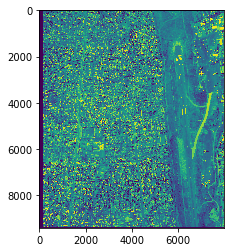

In [18]:
%matplotlib inline
plt.imshow(toparray_raw[:,:,0])

In [19]:
toparray = toparray_raw

In [20]:
#test_sample_points_arr.shape
#labelidx = np.where(test_sample_points_arr!=0)

In [21]:
#len(labelidx)
#labelidx[1]


In [20]:
#Now we prepare to predict the map
test_sample_points_arr = np.reshape(test_sample_pts,(test_sample_pts.shape[0],test_sample_pts.shape[1]))

#test_sample_points_arr = test_sample_points_arr[:2000,:2000]
def swap_axes(array):
    image_1 = np.swapaxes(array, 0, 1)
    image_2 = np.swapaxes (image_1,0, 2)
    image_3 = np.expand_dims(image_2, axis = 0)
    return image_3
    
area5_swapped = swap_axes(toparray)
image = area5_swapped

In [21]:
#image.shape
#Y_test.shape

NameError: name 'Y_test' is not defined

In [21]:
Y_test = test_sample_points_arr

In [22]:
a = np.zeros(shape =(toparray.shape[0],toparray.shape[1]))

mapidx_a_tile2 = sample_idx(a)

In [23]:
def evaluate_predictions(X_test,
                         w8fname,predsdir,
                         cut, overlap,
                         Y_test,mapidx,labels_pts_array):
    #nrows = Y_test.shape[0]
    #ncols = Y_test.shape[1]
    #nrows=8750
    #ncols=7970
    #nrows = 9320 #for tile 2
    #ncols = 7744
    nrows=X_test.shape[0]
    ncols=X_Test.shape[1]
    #nrows = 9407 
    #ncols = 7970
    total_map = np.zeros((nrows, ncols), dtype=np.uint8)
    first = True
    last = False
    if nrows%(cut)==0:
        numstrips = int((nrows/(cut)))
    else:
        numstrips = int((nrows/(cut)) + 1)
    for i in range(numstrips):
        print("Strip number: %d" % i)
        if first:
            striptop = 0
            stripbottom = overlap
            height = cut
            X_sub1 = X_test1[:, :,
                             cut*i-striptop:(cut*i)+height+stripbottom, :]
            first = False
        elif (not first) and (cut*(i+1)+1+overlap < nrows):
            striptop = overlap
            stripbottom = overlap
            height = cut
            X_sub1 = X_test1[:, :,
                             cut*i-striptop:(cut*i)+height+stripbottom, :]
        else:
            print("Last hit!")
            striptop = overlap
            stripbottom = 0
            height = nrows - cut*i
            X_sub1 = X_test1[:, :,
                             -(striptop+height):, :]
            last = True
            
        sub1_nrows = X_sub1.shape[2]
        sub1_ncols = X_sub1.shape[3]
        model = build_model(sub1_nrows, sub1_ncols,
                                nb, w8fname)
        #cmap = model.predict_on_batch([X_sub1])
        cmap = model.predict(X_sub1,batch_size=32)
        cmap = np.argmax(cmap[0], axis=0)
        if not last:
                total_map[cut*i:cut*i+height, :] = cmap[striptop:striptop+height, 0:total_map.shape[1]]
        else:
            height = nrows - cut*i
            total_map[cut*i:-1, :] = cmap[-(height):-1, 0:total_map.shape[1]]
            
    labelidx = np.where(labels_pts_array!=0)
    labels = labels_pts_array[labelidx]
    labels = labels.astype("uint8")
    labels = labels - 1
    
    #mapidx = sample_idx(rgtsarray)
    #print(mapidx.shape)
    #mapfname = predsdir + "fcn_vanilla_tile4_ol_ndsm_50.tif"
    mapfname = predsdir + "fcn_vanilla_weakly1_obia_tile4.tif"
    
    #calculate the oa
    cmap_sparse = total_map[labelidx]
    CM = get_confusion_matrix(cmap_sparse, labels)
    OA = np.sum(np.diag(CM))/cmap_sparse.size
    print(CM)
    print("Full OA: %f" % OA)
    
    
    #Make this section independent
    total_map = total_map.flatten()
    print (total_map.shape)
    print_map(total_map, mapidx,ccolors=_ccolors, filename=mapfname)

In [27]:
predsdir =tutorialdir + "predictions/"
cut = 50
overlap = 10
labels = Y_test

#image = area5_swapped[:,:,:2000,:2000]
#image = image [:,:,:2000,:2000]
t0 = time.time()
evaluate_predictions(image,
                     w8fname, predsdir,
                     cut, overlap,
                     labels,mapidx_a_tile2,test_sample_points_arr)

t1 = time.time()
print("Finished testing after %.2f mins" % ((t1-t0)/60.0))

Strip number: 0


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_191)`


Strip number: 1


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_192)`


Strip number: 2


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_193)`


Strip number: 3


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_194)`


Strip number: 4


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_195)`


Strip number: 5


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_196)`


Strip number: 6


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_197)`


Strip number: 7


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_198)`


Strip number: 8


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_199)`


Strip number: 9


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_200)`


Strip number: 10


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_201)`


Strip number: 11


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_202)`


Strip number: 12


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_203)`


Strip number: 13


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_204)`


Strip number: 14


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_205)`


Strip number: 15


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_206)`


Strip number: 16


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_207)`


Strip number: 17


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_208)`


Strip number: 18


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_209)`


Strip number: 19


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_210)`


Strip number: 20


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_211)`


Strip number: 21


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_212)`


Strip number: 22


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_213)`


Strip number: 23


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_214)`


Strip number: 24


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_215)`


Strip number: 25


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_216)`


Strip number: 26


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_217)`


Strip number: 27


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_218)`


Strip number: 28


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_219)`


Strip number: 29


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_220)`


Strip number: 30


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_221)`


Strip number: 31


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_222)`


Strip number: 32


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_223)`


Strip number: 33


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_224)`


Strip number: 34


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_225)`


Strip number: 35


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_226)`


Strip number: 36


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_227)`


Strip number: 37


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_228)`


Strip number: 38


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_229)`


Strip number: 39


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_230)`


Strip number: 40


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_231)`


Strip number: 41


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_232)`


Strip number: 42


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_233)`


Strip number: 43


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_234)`


Strip number: 44


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_235)`


Strip number: 45


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_236)`


Strip number: 46


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_237)`


Strip number: 47


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_238)`


Strip number: 48


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_239)`


Strip number: 49


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_240)`


Strip number: 50


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_241)`


Strip number: 51


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_242)`


Strip number: 52


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_243)`


Strip number: 53


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_244)`


Strip number: 54


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_245)`


Strip number: 55


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_246)`


Strip number: 56


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_247)`


Strip number: 57


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_248)`


Strip number: 58


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_249)`


Strip number: 59


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_250)`


Strip number: 60


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_251)`


Strip number: 61


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_252)`


Strip number: 62


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_253)`


Strip number: 63


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_254)`


Strip number: 64


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_255)`


Strip number: 65


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_256)`


Strip number: 66


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_257)`


Strip number: 67


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_258)`


Strip number: 68


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_259)`


Strip number: 69


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_260)`


Strip number: 70


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_261)`


Strip number: 71


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_262)`


Strip number: 72


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_263)`


Strip number: 73


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_264)`


Strip number: 74


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_265)`


Strip number: 75


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_266)`


Strip number: 76


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_267)`


Strip number: 77


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_268)`


Strip number: 78


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_269)`


Strip number: 79


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_270)`


Strip number: 80


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_271)`


Strip number: 81


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_272)`


Strip number: 82


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_273)`


Strip number: 83


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_274)`


Strip number: 84


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_275)`


Strip number: 85


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_276)`


Strip number: 86


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_277)`


Strip number: 87


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_278)`


Strip number: 88


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_279)`


Strip number: 89


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_280)`


Strip number: 90


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_281)`


Strip number: 91


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_282)`


Strip number: 92


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_283)`


Strip number: 93


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_284)`


Strip number: 94


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_285)`


Strip number: 95


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_286)`


Strip number: 96


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_287)`


Strip number: 97


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_288)`


Strip number: 98


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_289)`


Strip number: 99


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_290)`


Strip number: 100


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_291)`


Strip number: 101


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_292)`


Strip number: 102


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_293)`


Strip number: 103


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_294)`


Strip number: 104


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_295)`


Strip number: 105


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_296)`


Strip number: 106


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_297)`


Strip number: 107


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_298)`


Strip number: 108


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_299)`


Strip number: 109


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_300)`


Strip number: 110


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_301)`


Strip number: 111


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_302)`


Strip number: 112


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_303)`


Strip number: 113


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_304)`


Strip number: 114


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_305)`


Strip number: 115


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_306)`


Strip number: 116


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_307)`


Strip number: 117


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_308)`


Strip number: 118


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_309)`


Strip number: 119


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_310)`


Strip number: 120


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_311)`


Strip number: 121


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_312)`


Strip number: 122


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_313)`


Strip number: 123


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_314)`


Strip number: 124


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_315)`


Strip number: 125


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_316)`


Strip number: 126


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_317)`


Strip number: 127


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_318)`


Strip number: 128


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_319)`


Strip number: 129


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_320)`


Strip number: 130


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_321)`


Strip number: 131


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_322)`


Strip number: 132


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_323)`


Strip number: 133


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_324)`


Strip number: 134


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_325)`


Strip number: 135


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_326)`


Strip number: 136


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_327)`


Strip number: 137


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_328)`


Strip number: 138


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_329)`


Strip number: 139


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_330)`


Strip number: 140


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_331)`


Strip number: 141


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_332)`


Strip number: 142


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_333)`


Strip number: 143


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_334)`


Strip number: 144


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_335)`


Strip number: 145


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_336)`


Strip number: 146


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_337)`


Strip number: 147


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_338)`


Strip number: 148


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_339)`


Strip number: 149


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_340)`


Strip number: 150


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_341)`


Strip number: 151


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_342)`


Strip number: 152


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_343)`


Strip number: 153


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_344)`


Strip number: 154


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_345)`


Strip number: 155


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_346)`


Strip number: 156


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_347)`


Strip number: 157


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_348)`


Strip number: 158


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_349)`


Strip number: 159


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_350)`


Strip number: 160


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_351)`


Strip number: 161


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_352)`


Strip number: 162


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_353)`


Strip number: 163


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_354)`


Strip number: 164


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_355)`


Strip number: 165


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_356)`


Strip number: 166


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_357)`


Strip number: 167


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_358)`


Strip number: 168


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_359)`


Strip number: 169


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_360)`


Strip number: 170


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_361)`


Strip number: 171


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_362)`


Strip number: 172


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_363)`


Strip number: 173


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_364)`


Strip number: 174


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_365)`


Strip number: 175


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_366)`


Strip number: 176


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_367)`


Strip number: 177


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_368)`


Strip number: 178


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_369)`


Strip number: 179


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_370)`


Strip number: 180


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_371)`


Strip number: 181


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_372)`


Strip number: 182


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_373)`


Strip number: 183


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_374)`


Strip number: 184


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_375)`


Strip number: 185


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_376)`


Strip number: 186


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_377)`


Strip number: 187
Last hit!


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_378)`


Strip number: 188
Last hit!


C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_379)`


[[ 288.    1.    3.   15.    0.]
 [   0.  166.    1.    6.    1.]
 [   6.    8.   85.   18.    0.]
 [  14.    3.    1.  279.    0.]
 [   4.    1.    0.   19.   75.]]
Full OA: 0.898390
(74973790L,)
Finished testing after 25.10 mins


In [ ]:
##TESTING the classifier

In [ ]:
#manual testing of the classification accuracy 

Y_test = rgtsarray
Y_test = Y_test[:1000,:1000]
#plt.imshow(lab_arr)
labelidx = np.where(Y_test!=0)
labels = Y_test[labelidx]
labels = labels.astype("uint8")
labels = labels - 1
mapidx = cartesian([range(cmap.shape[0]), range(cmap.shape[1])])
cmap_sparse = cmap[labelidx]
CM = get_confusion_matrix(cmap_sparse, labels)
OA = np.sum(np.diag(CM))/cmap_sparse.size

print(CM)
print("Full OA: %f" % OA)


In [30]:
test_sample_arr = "H:/BUKAVU-2018/PRELIM_CNN/GTS_IMAGES/tile4_img.tiff"
"loading the data for tile 2"
ts1,ts2 = img_to_array(test_sample_arr,test_sample_arr)

In [32]:
ts1.shape

(9407L, 7970L, 1L)

In [27]:
#Reclassifying the array and giving it coordinates
def reclass_gts(gtsarray):
    """Reclassify ground truth dataset array to single class numbers.

    Keyword arguments:
    gtsarray -- the ground truth dataset array
    """
    reclassarray = np.zeros(shape=(gtsarray.shape[0], gtsarray.shape[1]),
                            dtype=np.uint8)
    cnum = 1
    for color in _ccolors:
        mask = np.logical_and(np.logical_and(gtsarray[:, :, 0] == color[0],
                              gtsarray[:, :, 1] == color[1]),
                              gtsarray[:, :, 2] == color[2])
        reclassarray[mask] = cnum
        cnum += 1

    # print("Maximum label:")
    # print(reclassarray.max())
    # print("Minimum label:")
    # print(reclassarray.min())
    return reclassarray

#saving the image in a gc
#pred_map= predsdir + "fcn_vanilla_weakly1_tile4.tif"
pred_map= predsdir + "fcn_vanilla_weakly1_obia_tile4.tif"
pred_map1,pred_map_del = img_to_array(pred_map,pred_map)

"reclassifying the classified map"

P_rec= reclass_gts(pred_map1)
P_rec1 = np.expand_dims(P_rec,axis=2)

pred_map_GCs = predsdir + "fcn_vanilla_weakly1_obia_tile4_3bands.tif"

nrows,ncols,nbands = pred_map1.shape[0],pred_map1.shape[1],pred_map1.shape[2]
driver = gdal.GetDriverByName('GTiff')
nw_ds = driver.Create(pred_map_GCs, ncols, nrows, nbands, gdal.GDT_UInt32 )
nw_ds.SetGeoTransform(geo_transform)
nw_ds.SetProjection(proj)

for i in range(nbands):
	nw_ds.GetRasterBand(i+1).WriteArray(pred_map1[:, :, i])

nw_ds = None


In [28]:
#save a one band image
#p_rec is the reclassified array and has two dimensions
pred_map_GCs2 = predsdir + "fcn_vanilla_weakly1_obia_tile4_1bands.tif"
nrows,ncols,nbands = P_rec1.shape[0],P_rec1.shape[1],P_rec1.shape[2]
driver = gdal.GetDriverByName('GTiff')
nw_ds = driver.Create(pred_map_GCs2, ncols, nrows, nbands, gdal.GDT_UInt32 )
nw_ds.SetGeoTransform(geo_transform)
nw_ds.SetProjection(proj)

nw_ds.GetRasterBand(1).WriteArray(P_rec1[:, :,0])

#for i in range(nbands):
#	nw_ds.GetRasterBand(i+1).WriteArray(P_rec[:, :, i])

nw_ds = None